In [70]:
import torch
import torch.nn as nn  # 신경망 모듈, 구축 및 훈련에 사용
from torch.utils.data.dataset import Dataset # 사용자 정의 데이터 셋을 만들어 딥러닝을 할 수 있게 함
import torchvision.transforms as T # 이미지 전처리에 필요한 transform 사용
from torch.utils.data import DataLoader # 데이터 관리에 필요한 dataloader
import torch.nn.functional as F # loss or cost gradient와 같은 여러 함수를 사용할 수 있음
from sklearn.metrics import f1_score, confusion_matrix # f1 score와 행렬을 계산 -> 모델의 성능 평가
import pandas as pd # pandas를 사용한 데이터 조작 및 분석
import numpy as np # numpy 사용
import matplotlib.pyplot as plt #시각화를 위한 차트 사용
from matplotlib import pyplot as plt
import seaborn as sns
!pip install torchinfo
from torchinfo import summary

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:

fer2013_dataset_file_path = '/content/drive/MyDrive/Colab Notebooks/fer2013.csv'

In [73]:
# 7개 감정을 각 요소로 가지는 클래스 레이블 정의
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
NUM_CLASSES = len(CLASS_LABELS) # 변수에 7개 저장
#dictionary -> Class index, label을 각각 연결하여서 매핑정보를 형성하는데 유용
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

In [74]:
df = pd.read_csv(fer2013_dataset_file_path) #pandas를 사용하여 csv에서 데이터를 읽음 -> 데이터프레임으로 변환
df #데이터프레임에서 반환

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


df.groupby('Usage').size(): 'Usage' 열을 기준으로 데이터프레임을 그룹화하고, 각 그룹의 크기(빈도)를 계산합니다.

.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2')): 그룹화된 크기를 수평 막대 그래프로 시각화합니다. kind='barh'는 수평 막대 그래프를 생성하라는 옵션이며, color=sns.palettes.mpl_palette('Dark2')는 Seaborn 팔레트에서 'Dark2' 색상을 사용하여 막대의 색을 지정합니다.


plt.gca().spines[['top', 'right',]].set_visible(False): 그래프의 상단과 오른쪽 테두리를 제거합니다. plt.gca()는 현재 축(axes)을 가져오는 함수이고, spines[['top', 'right',]].set_visible(False)는 상단과 오른쪽 테두리를 숨김 처리합니다.

In [75]:
class tensorDataset(Dataset):

# 클래스 생성자 -> 이미지 텐서, 레이블 텐서, 데이터 증강 적용 여부인 train
    def __init__(self, images, labels, train:bool):
        self.images = images/255
        self.labels = labels
        self.train  = train

# 이미지와 레이블을 반환 trainsform 함수로 이미지 Augmentation 적용
    def __getitem__(self, index):

        # Load the image (as tensor)
        img  = self.images[index]
        label = self.labels[index]

        # Apply transformations
        if self.train == True:
            img = self.transform(img)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)

        return img, label

# 데이터 셋의 전체 길이 반환
    def __len__(self):
        return len(self.images)

# 이미지에 변환주기 -> Image Augmentation
    def transform(self, img):
        # 좌우 반전
        if np.random.rand() < 0.3:
            t_horizontal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizontal_flip(img)

        # 각도 조절
        if np.random.rand() < 0.3:
            t_rotation = T.RandomRotation(degrees=(-20, 20))
            img = t_rotation(img)

        return img

In [76]:
# 각 데이터셋들에 대한 Tensor 형태 데이터넷 생성 + Dataloader 생성, 배치 크기에 따른 미니배치 적용

def create_dataloaders(batch_size, X_train, y_train, X_val, y_val, X_test=None, y_test=None):

    train_dataset = tensorDataset(X_train, y_train, train=True)
    val_dataset   = tensorDataset(X_val, y_val, train=False)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

    if X_test is not None:
        test_dataset  = tensorDataset(X_test, y_test, train=False)
        test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
        return train_dataloader, val_dataloader, test_dataloader

    return train_dataloader, val_dataloader

In [77]:
class Modified_ED_Deep_Model(nn.Module):
    def __init__(self, dropout):
        super(Modified_ED_Deep_Model, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 48 -> 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 24 -> 12 RF=14

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =12 -> 6 RF=20

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             nn.Dropout(dropout_value)
         )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = F.avg_pool2d(x, 6)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Modified_ED_Deep_Model(dropout=0.3).to(device)
summary(model, input_size=(99, 1, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
Modified_ED_Deep_Model                   [99, 7]                   --
├─Sequential: 1-1                        [99, 32, 48, 48]          --
│    └─Conv2d: 2-1                       [99, 32, 48, 48]          288
│    └─ReLU: 2-2                         [99, 32, 48, 48]          --
│    └─BatchNorm2d: 2-3                  [99, 32, 48, 48]          64
│    └─Dropout: 2-4                      [99, 32, 48, 48]          --
├─Sequential: 1-2                        [99, 64, 48, 48]          --
│    └─Conv2d: 2-5                       [99, 64, 48, 48]          18,432
│    └─ReLU: 2-6                         [99, 64, 48, 48]          --
│    └─BatchNorm2d: 2-7                  [99, 64, 48, 48]          128
│    └─Dropout: 2-8                      [99, 64, 48, 48]          --
├─MaxPool2d: 1-3                         [99, 64, 24, 24]          --
├─Sequential: 1-4                        [99, 128, 24, 24]         --
│    └─Co

In [80]:
def train():

    for epoch in range(1, EPOCHS+1):

        # Train model
        model.train()
        train_losses   = []
        train_accuracy = []
        train_f1       = []

        for i, batch in enumerate(train_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Train model
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 7, H, W]
            loss   = criterion(output, label_batch)
            loss.backward()
            optimizer.step()

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            train_losses.append(loss.item())
            train_accuracy.append(acc.cpu())
            train_f1.append(f1)
            # print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}, learning rate: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        total_train_losses.append(np.mean(train_losses))
        total_train_accuracy.append(np.mean(train_accuracy))
        total_train_f1.append(np.mean(train_f1))

        #Update learning rate
        learning_rate_tracker.append(optimizer.state_dict()['param_groups'][0]['lr'])
        scheduler.step()

        # Validate model
        model.eval()
        val_losses   = []
        val_accuracy = []
        val_f1       = []

        for i, batch in enumerate(val_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Validate model
            with torch.cuda.amp.autocast():
                output = model(img_batch)
                loss   = criterion(output, label_batch)

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            val_losses.append(loss.item())
            val_accuracy.append(acc.cpu())
            val_f1.append(f1)
            # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
        print('-'*106)
        total_val_losses.append(np.mean(val_losses))
        total_val_accuracy.append(np.mean(val_accuracy))
        total_val_f1.append(np.mean(val_f1))


        # Save the results so far
        temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
        temp_df.to_csv('train_val_measures')

In [81]:
# HYPERPARAMETERS for training run
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 40
LR = 0.01
BATCH_SIZE = 256

dropout_value = 0.5  # 예시로 dropout 값을 지정
model = Modified_ED_Deep_Model(dropout=dropout_value).to(DEVICE)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE, X_train, y_train, X_val, y_val, X_test, y_test)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(DEVICE)

total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []
learning_rate_tracker = []

In [82]:
train()

TRAIN       Epoch: 1 | Epoch metrics | loss: 1.8426, f1: 0.145, accuracy: 0.241, learning rate: 0.010000
VALIDATION  Epoch: 1 | Epoch metrics | loss: 4.3677, f1: 0.093, accuracy: 0.246
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 1.7309, f1: 0.194, accuracy: 0.298, learning rate: 0.010000
VALIDATION  Epoch: 2 | Epoch metrics | loss: nan, f1: 0.093, accuracy: 0.175
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 1.5735, f1: 0.280, accuracy: 0.386, learning rate: 0.010000
VALIDATION  Epoch: 3 | Epoch metrics | loss: nan, f1: 0.134, accuracy: 0.244
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 1.4098, f1: 0.355, accuracy: 0.455, learning rate: 0.010000
VALIDATION  Epoch: 4 | Ep

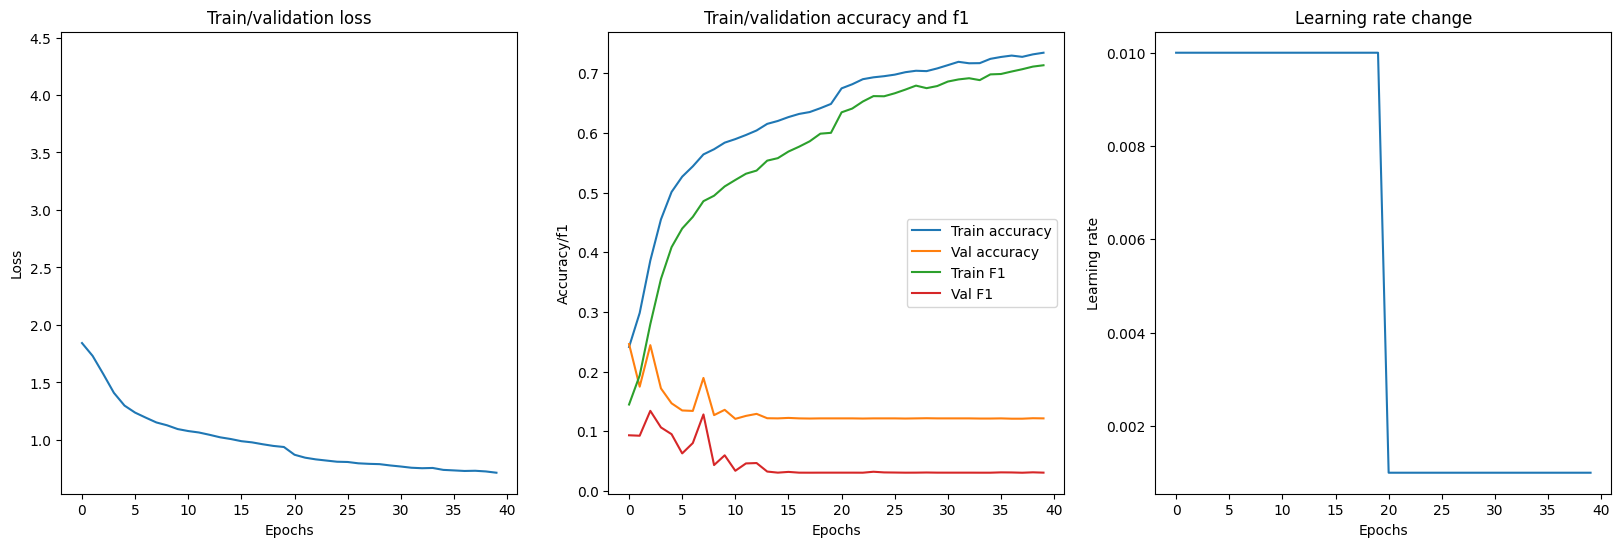

In [83]:
f, axarr = plt.subplots(1,3, figsize = (20,6))
axarr[0].plot(list(range(len(total_train_losses))), total_train_losses)
axarr[0].plot(list(range(len(total_train_losses))), total_val_losses)
axarr[0].set_title('Train/validation loss')
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[1].plot(list(range(len(total_train_accuracy))), total_train_accuracy, label='Train accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_accuracy, label='Val accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_train_f1, label='Train F1')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_f1, label='Val F1')
axarr[1].set_title('Train/validation accuracy and f1')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy/f1')
axarr[1].legend()

axarr[2].plot(np.arange(len(learning_rate_tracker)), learning_rate_tracker)
axarr[2].set_title('Learning rate change')
axarr[2].set_xlabel('Epochs')
axarr[2].set_ylabel('Learning rate')
plt.show()